In [1]:
%%capture
!pip install numpy pandas matplotlib scikit-learn tensorflow statsmodels requests

In [2]:
import requests
import pandas as pd

def fetch_token_data(token_id, days='365'):
    url = f"https://api.coingecko.com/api/v3/coins/{token_id}/market_chart"
    params = {
        'vs_currency': 'usd',
        'days': days,
        'precision': '0'
    }
    response = requests.get(url, params=params)
    data = response.json()
    prices = data['prices']
    df = pd.DataFrame(prices, columns=['timestamp', 'price'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

# Example: Fetch Bitcoin data
token_id = 'bitcoin'
data = fetch_token_data(token_id)
print(data.head())
print(data.tail())

            price
timestamp        
2024-01-17  43148
2024-01-18  42714
2024-01-19  41261
2024-01-20  41601
2024-01-21  41626
                     price
timestamp                 
2025-01-12 00:00:00  94560
2025-01-13 00:00:00  94455
2025-01-14 00:00:00  94456
2025-01-15 00:00:00  96574
2025-01-15 18:13:44  98856


In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['price']])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model and store the history
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test))

# Predict using the LSTM model
lstm_predictions = model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 319ms/step - loss: 0.1248 - val_loss: 0.0243
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 0.0120 - val_loss: 0.0685
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 0.0069 - val_loss: 0.0918
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0040 - val_loss: 0.0283
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0046 - val_loss: 0.0606
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0045 - val_loss: 0.0559
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0039 - val_loss: 0.0443
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0049 - val_loss: 0.0479
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0034 - val_loss: 0.0425
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0039 - val_loss: 0.0341
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0029 - val_loss: 0.0374
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0035 - va

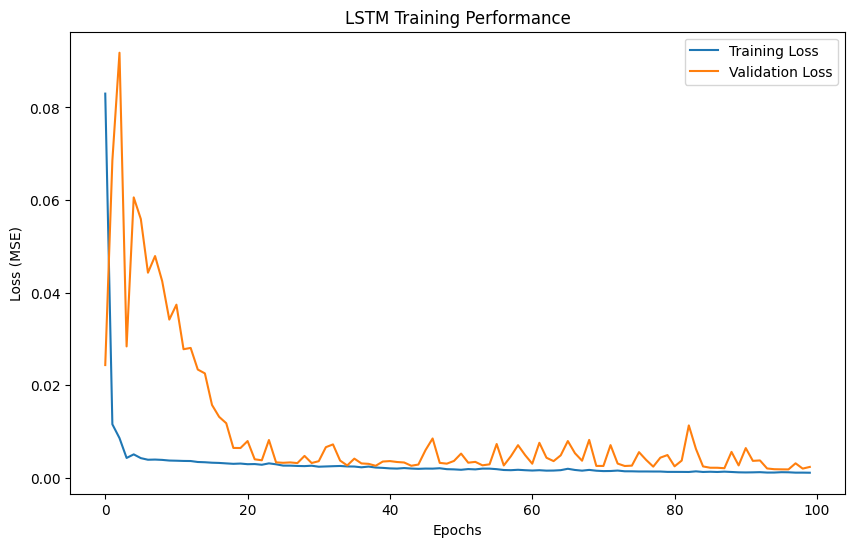

In [6]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [7]:
from sklearn.ensemble import RandomForestRegressor

# Reshape the data for Random Forest
X_train_rf = X_train.reshape(X_train.shape[0], -1)
X_test_rf = X_test.reshape(X_test.shape[0], -1)

# # Train the Random Forest model
# rf_model = RandomForestRegressor(n_estimators=100)
# rf_model.fit(X_train_rf, y_train)

# # Predict using the Random Forest model
# rf_predictions = rf_model.predict(X_test_rf)
# rf_predictions = scaler.inverse_transform(rf_predictions.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

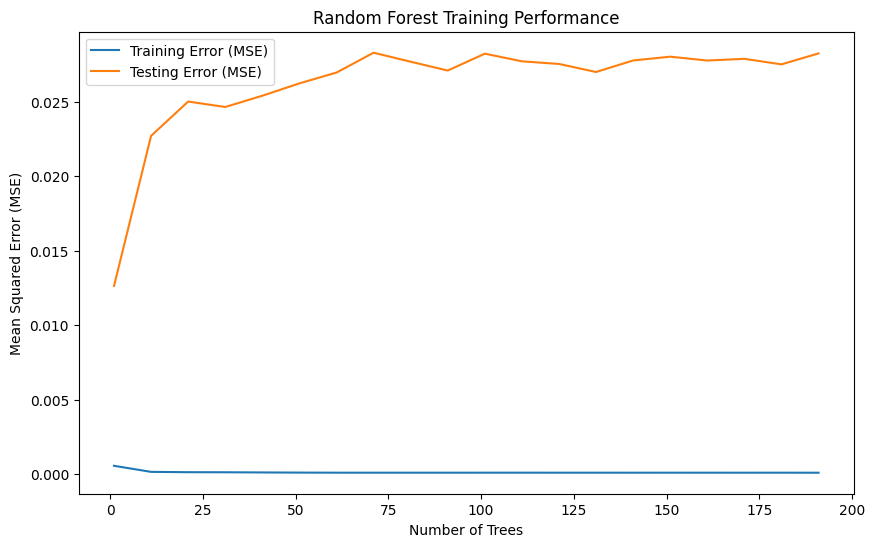

In [8]:
from sklearn.metrics import mean_squared_error

# Track training error as a function of the number of trees
train_errors = []
test_errors = []
n_estimators_range = range(1, 201, 10)  # Test 1 to 200 trees in steps of 10

for n_estimators in n_estimators_range:
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    rf_model.fit(X_train_rf, y_train)

    # Training error
    train_pred = rf_model.predict(X_train_rf)
    train_errors.append(mean_squared_error(y_train, train_pred))

    # Testing error
    test_pred = rf_model.predict(X_test_rf)
    test_errors.append(mean_squared_error(y_test, test_pred))

# Predict using the Random Forest model
rf_predictions = rf_model.predict(X_test_rf)
rf_predictions = scaler.inverse_transform(rf_predictions.reshape(-1, 1))

# Plot training and testing errors
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_errors, label='Training Error (MSE)')
plt.plot(n_estimators_range, test_errors, label='Testing Error (MSE)')
plt.title('Random Forest Training Performance')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

In [9]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
arima_model = ARIMA(data['price'], order=(5, 1, 0))
arima_model_fit = arima_model.fit()

# Predict using the ARIMA model
arima_predictions = arima_model_fit.forecast(steps=len(y_test))
arima_predictions = arima_predictions.values.reshape(-1, 1)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

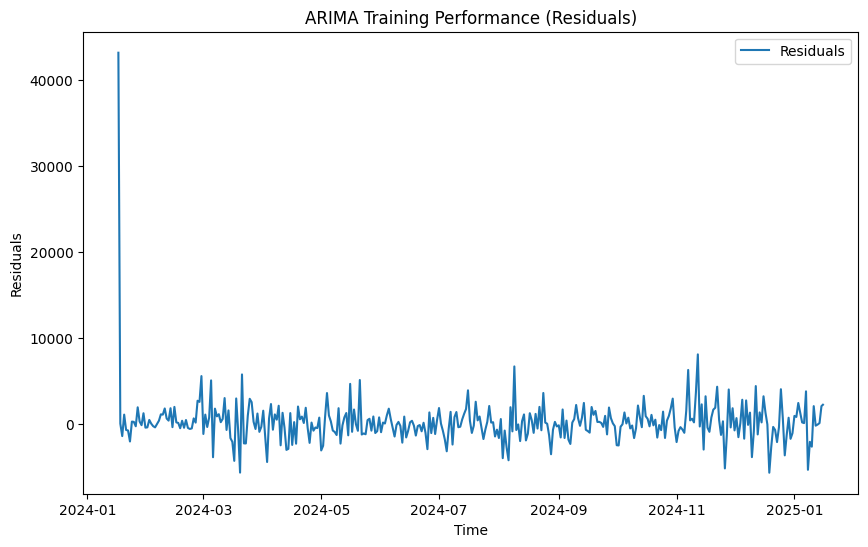

In [10]:
# Fit ARIMA and plot residuals
# arima_model_fit = arima_model.fit()
residuals = pd.DataFrame(arima_model_fit.resid)

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.title('ARIMA Training Performance (Residuals)')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluate LSTM
lstm_mae = mean_absolute_error(y_test_actual, lstm_predictions)
lstm_mse = mean_squared_error(y_test_actual, lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)

# Evaluate Random Forest
rf_mae = mean_absolute_error(y_test_actual, rf_predictions)
rf_mse = mean_squared_error(y_test_actual, rf_predictions)
rf_rmse = np.sqrt(rf_mse)

# Evaluate ARIMA
arima_mae = mean_absolute_error(y_test_actual, arima_predictions)
arima_mse = mean_squared_error(y_test_actual, arima_predictions)
arima_rmse = np.sqrt(arima_mse)

print(f"LSTM - MAE: {lstm_mae}, MSE: {lstm_mse}, RMSE: {lstm_rmse}")
print(f"Random Forest - MAE: {rf_mae}, MSE: {rf_mse}, RMSE: {rf_rmse}")
print(f"ARIMA - MAE: {arima_mae}, MSE: {arima_mse}, RMSE: {arima_rmse}")

LSTM - MAE: 2435.597152217742, MSE: 10223533.996833064, RMSE: 3197.4261518967196
Random Forest - MAE: 10664.93590609703, MSE: 125101514.53043482, RMSE: 11184.878833963057
ARIMA - MAE: 3244.646932871553, MSE: 16160186.330822106, RMSE: 4019.97342414376


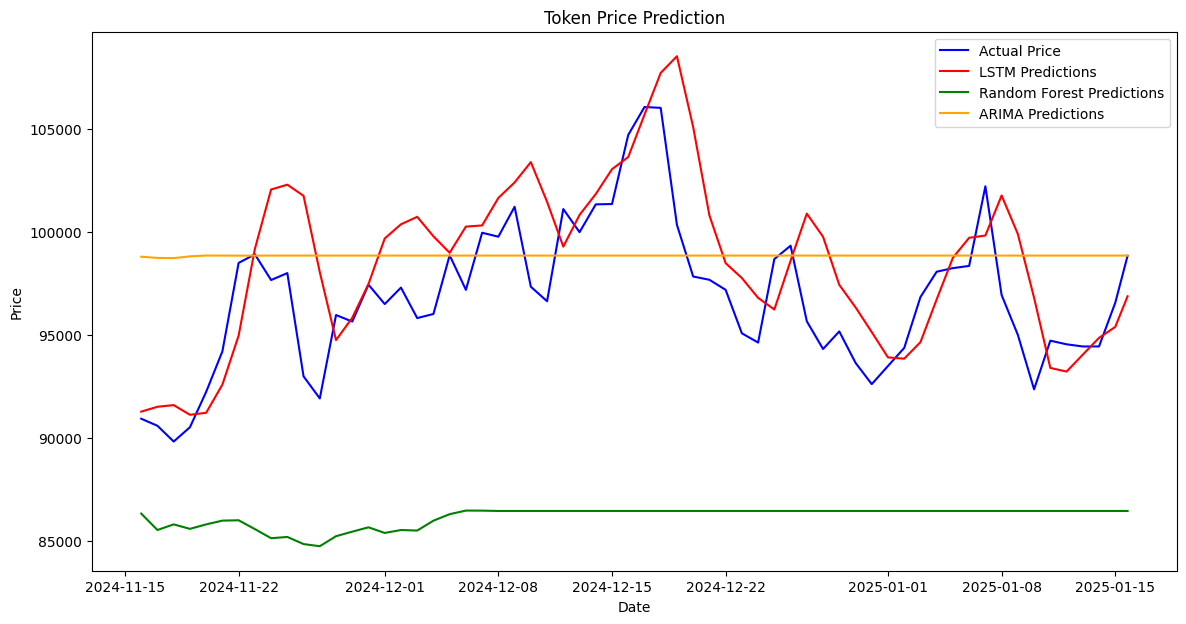

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], y_test_actual, label='Actual Price', color='blue')
plt.plot(data.index[-len(y_test):], lstm_predictions, label='LSTM Predictions', color='red')
plt.plot(data.index[-len(y_test):], rf_predictions, label='Random Forest Predictions', color='green')
plt.plot(data.index[-len(y_test):], arima_predictions, label='ARIMA Predictions', color='orange')
plt.title('Token Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

           Model           MAE           MSE          RMSE
0           LSTM   2435.597152  1.022353e+07   3197.426152
1  Random Forest  10664.935906  1.251015e+08  11184.878834
2          ARIMA   3244.646933  1.616019e+07   4019.973424


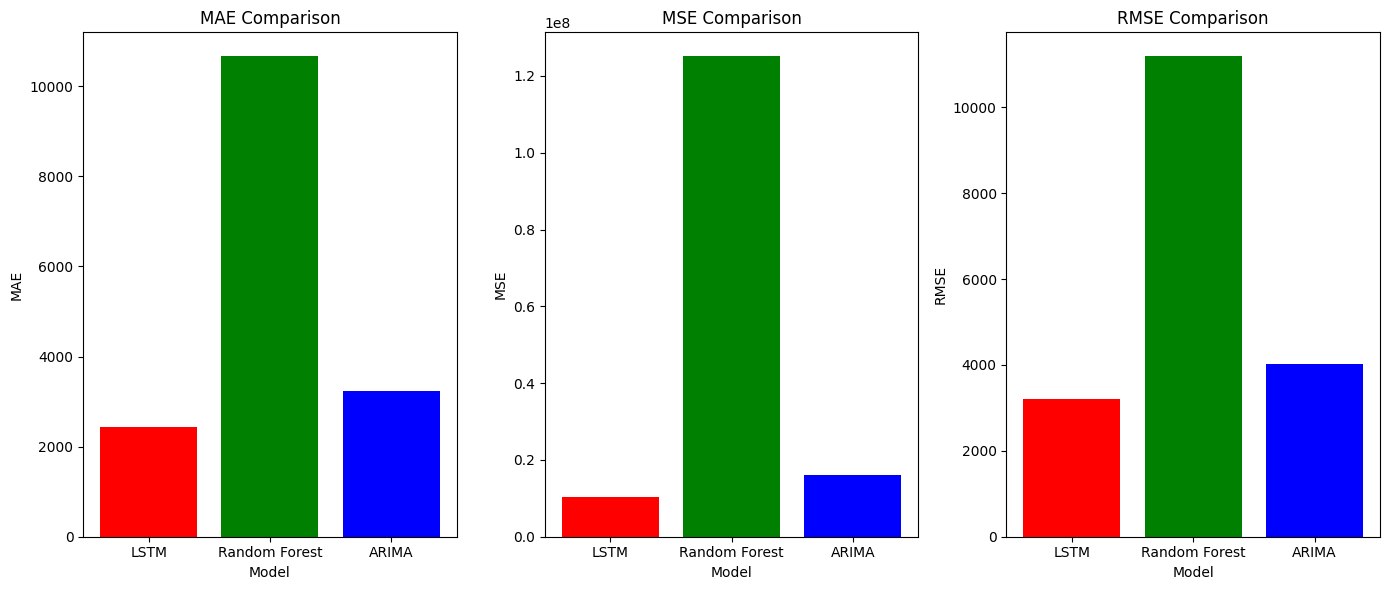

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Performance metrics for each model
metrics = {
    'Model': ['LSTM', 'Random Forest', 'ARIMA'],
    'MAE': [lstm_mae, rf_mae, arima_mae],
    'MSE': [lstm_mse, rf_mse, arima_mse],
    'RMSE': [lstm_rmse, rf_rmse, arima_rmse]
}

# Create a DataFrame for comparison
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Plotting the comparison
plt.figure(figsize=(14, 6))

# MAE Comparison
plt.subplot(1, 3, 1)
plt.bar(metrics_df['Model'], metrics_df['MAE'], color=['red', 'green', 'blue'])
plt.title('MAE Comparison')
plt.xlabel('Model')
plt.ylabel('MAE')

# MSE Comparison
plt.subplot(1, 3, 2)
plt.bar(metrics_df['Model'], metrics_df['MSE'], color=['red', 'green', 'blue'])
plt.title('MSE Comparison')
plt.xlabel('Model')
plt.ylabel('MSE')

# RMSE Comparison
plt.subplot(1, 3, 3)
plt.bar(metrics_df['Model'], metrics_df['RMSE'], color=['red', 'green', 'blue'])
plt.title('RMSE Comparison')
plt.xlabel('Model')
plt.ylabel('RMSE')

plt.tight_layout()
plt.show()